<a href="https://colab.research.google.com/github/ramahasiba/NLP/blob/langGraph/Build_a_Retrieval_Augmented_Generation_App_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Build a Retrieval Augmented Generation App Part 2](https://python.langchain.com/docs/tutorials/qa_chat_history/)

In [1]:
!pip install -qU "langchain[groq]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 3.9 MB/s eta 0:00:00


In [2]:
!pip install dotenv -q
from dotenv import load_dotenv
try:
  load_dotenv('.env')
except ImportError:
  print('No .env file found')

In [3]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.environ.get("LANGSMITH_API_KEY")

In [4]:
os.environ["GROQ_API_KEY"]=os.environ.get("GROQ_API_KEY")

model_name = "llama3-70b-8192"

from langchain.chat_models import init_chat_model
llm=init_chat_model(model_name, model_provider="groq")

In [5]:
!pip install -qU langchain-huggingface

from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
!pip install -qU langchain-chroma

from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 7.6 MB/s eta 

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [7]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4 -q

In [8]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))
    )
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
all_splits= text_splitter.split_documents(docs)

In [9]:
_ = vector_store.add_documents(all_splits)

In [10]:
from langgraph.graph import MessagesState, StateGraph
graph_builder = StateGraph(MessagesState)


In [11]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
  """Retrieve information related to a query"""
  retrieved_docs = vector_store.similarity_search(query, k=2)
  serialized = "\n\n".join(
      (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}") for doc in retrieved_docs
  )
  return serialized, retrieved_docs

In [12]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Step 1: generate AI Message that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
  """Generate tool call for retrieval or respond."""
  llm_with_tools = llm.bind_tools([retrieve])
  response = llm_with_tools.invoke(state["messages"])
  # MessagesState appends messages to state instead of overwriting
  return {"messages": [response]}

# Step 2: Execute the retrieval
tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
  """Generate answer."""
  # Get generated toolMessagaes
  recent_tool_messages = []
  for message in reversed(state["messages"]):
    if message.type == "tool":
      recent_tool_messages.append(message)
    else:
      break
  tool_messages = recent_tool_messages[::-1]

  # Format into prompt
  docs_content = "\n\n".join(doc.content for doc in tool_messages)
  system_message_content = (
      "You are an assistant for question-answering tasks."
      "Use the following pieces of retrieved context to answer"
      "the question. If you don't know the answer, say that you"
      "don't know. Use three senences maximum and keep the answer concise.\n\n"
      f"{docs_content}"
  )

  conversation_messages =[
      message
      for message in state["messages"]
      if message.type in ("human", "system")
      or (message.type == "ai" and not message.tool_calls)
  ]
  prompt = [SystemMessage(system_message_content)] + conversation_messages

  #Run
  response = llm.invoke(prompt)
  return {"messages": [response]}

In [13]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"}
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

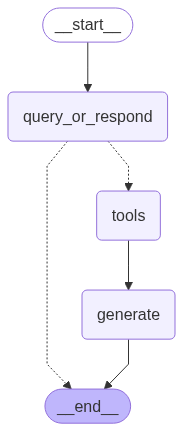

In [14]:
graph

In [19]:
system_message = SystemMessage(content="Only call tools if the user is asking a factual or knowledge-based question. Otherwise, respond directly.")

In [22]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [system_message, {"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [23]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (9q1zhw948)
 Call ID: 9q1zhw948
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this proc

In [24]:
input_message = "What is the temprature today?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the temprature today?
================================== Ai Message ==================================
Tool Calls:
  retrieve (pmtr90vha)
 Call ID: pmtr90vha
  Args:
    query: temperature today
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Prompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.


Planning & Reacting: translate the reflections and the environment information into actions

Planning is essentially in order to optimize believability at the moment vs in time.
Prompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)
Relationships between agents and observations of one agent by another are all taken into consid

In [25]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# specify an ID for the thread
config = {"configurable": {"thread_id": "a"}}

In [26]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3gk9mfkcv)
 Call ID: 3gk9mfkcv
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this proc

In [27]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (9e3gwqezj)
 Call ID: 9e3gwqezj
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe t

In [28]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

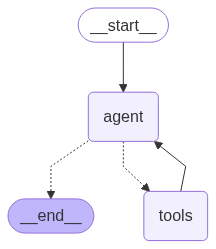

In [29]:
agent_executor

In [30]:
config = {"configurable": {"thread_id": "b"}}

input_message = (
    "what is the standard method for task decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
):
  event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the standard method for task decomposition?

Once you get the answer, look up common extensions of that method
================================== Ai Message ==================================
Tool Calls:
  retrieve (10nc4yqv9)
 Call ID: 10nc4yqv9
  Args:
    query: standard method for task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Plannin